# Italian market portfolio optimization

In [71]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
from utils import *
from Dataset.datasets import *
from Dataset.aggregation import *
from Dataset.metrics import *
from Optimization.clustering import *
from Optimization.portfolio_opt import *
from Evaluation.evaluate import *
from Evaluation.Plot_results import *
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dates for training and evaluation

In [2]:
start_date_train = '2006-06-01'
end_date_train = '2016-01-01'

start_date_validation = '2016-01-01'
end_date_validation = '2024-01-23'


## Dataset preparation

In [3]:
df = download_stock_data(market_country ='IT', start_date = '2006-01-01',)

[*********************100%%**********************]  365 of 365 completed

72 Failed downloads:
['AMM.MI', 'YIV.MI', 'MS.MI', 'ASR.MI', 'MOLD.MI', 'ROS.MI', 'FED.MI', 'LD.MI', 'DEA.MI', 'CVAL.MI', 'WMC.MI', 'EC.MI', 'LIT.MI', 'ATH.MI', 'RM.MI', 'ELIN.MI', 'VTY.MI', 'CERV.MI', 'CRES.MI', 'AT.MI', 'COV.MI', 'BEST.MI', 'SEB.MI', 'ISGS.MI', 'TAS.MI', 'TIS.MI', 'EMC.MI', 'PSA.MI', 'BCM.MI', 'ACS.MI', 'FNL.MI', 'LBM.MI', 'AGL.MI', 'DIG.MI', 'BDBR.MI', 'MT.MI', 'ESI.MI', 'AED.MI', 'TTT.MI', 'PITE.MI', 'IKG.MI', 'FKR.MI', 'PAN.MI', 'EXSY.MI', 'EVS.MI', 'REEVO.MI', 'BOR.MI', 'FUL.MI', 'SGR.MI', 'PSF.MI', 'AST.MI', 'BIM.MI', 'CARR.MI', 'KI.MI', 'SITI.MI', 'ASSI.MI', 'FHR.MI', 'GCL.MI', 'KIP.MI', 'SICT.MI', 'PLT.MI', 'BLUE.MI', 'SOU.MI', 'MAIL.MI', 'NET.MI', 'FAR.MI', 'SIO.MI', 'PRI.MI', 'ATL.MI', 'ISG.MI', 'BFE.MI']: Exception('%ticker%: No timezone found, symbol may be delisted')
['EPR.MI']: Exception('%ticker%: No data found, symbol may be delisted')


In [4]:
df.head()

adj close      close       high        low       open  \
date       ticker                                                            
2006-01-02 A2A.MI     0.696583   1.621000   1.623000   1.605000   1.605000   
           ACE.MI     3.695695   8.360000   8.420000   8.350000   8.420000   
           AMP.MI     4.782180   5.672000   5.734000   5.655000   5.700000   
           ARN.MI     3.309356   4.445000   4.495000   4.400000   4.455000   
           AUTME.MI   3.744271  36.990002  36.990002  36.990002  36.990002   

                        volume  
date       ticker               
2006-01-02 A2A.MI    1282006.0  
           ACE.MI      35926.0  
           AMP.MI      27050.0  
           ARN.MI      27939.0  
           AUTME.MI      902.0

In [5]:
stock_measures = StockMeasures(df)
stock_measures.calculate_measures('all')
stock_measures.measures

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                      
2006-01-02 A2A.MI           -0.269073        NaN       NaN       NaN   
           ACE.MI           -0.261894        NaN       NaN       NaN   
           AMP.MI           -0.011811        NaN       NaN       NaN   
           ARN.MI           -0.033909        NaN       NaN       NaN   
           AUTME.MI         -2.026511        NaN       NaN       NaN   
...                               ...        ...       ...       ...   
2024-01-26 XPR.MI            0.000049  48.229240  0.955342  0.974964   
           YRM.MI            0.000000  50.801228  3.831594  3.890772   
           YSFT.MI           0.000466  25.351526  0.446122  0.586895   
           ZUC.MI            0.000000  49.175472  1.158934  1.187588   
           ZV.MI             0.000207  58.899423  2.657193  2.693315   

                      bb_high       atr      macd  dollar_volume  
date       ticker                                                 
2006-01-02 A2A.MI         NaN       NaN       NaN       0.893024  
           ACE.MI         NaN       NaN       NaN       0.132772  
           AMP.MI         NaN       NaN       NaN       0.129358  
           ARN.MI         NaN       NaN       NaN       0.092460  
           AUTME.MI       NaN       NaN       NaN       0.003377  
...                       ...       ...       ...            ...  
2024-01-26 XPR.MI    0.994586 -0.791388 -0.791388       0.011701  
           YRM.MI    3.949950  3.645307  3.645307       0.000000  
           YSFT.MI   0.727668  0.069444  0.069444       0.009234  
           ZUC.MI    1.216242 -0.694172 -0.694172       0.000000  
           ZV.MI     2.729436  0.998393  0.998393       1.312685  

[877422 rows x 8 columns]

Now we add to the feature dataframe the columns of adjusted close and volume. 

In [6]:
data_fit = stock_measures.measures.copy()
data_fit["adj close"] = df["adj close"]
data_fit.head()

garman_klass_vol  rsi  bb_low  bb_mid  bb_high  atr  \
date       ticker                                                          
2006-01-02 A2A.MI           -0.269073  NaN     NaN     NaN      NaN  NaN   
           ACE.MI           -0.261894  NaN     NaN     NaN      NaN  NaN   
           AMP.MI           -0.011811  NaN     NaN     NaN      NaN  NaN   
           ARN.MI           -0.033909  NaN     NaN     NaN      NaN  NaN   
           AUTME.MI         -2.026511  NaN     NaN     NaN      NaN  NaN   

                     macd  dollar_volume  adj close  
date       ticker                                    
2006-01-02 A2A.MI     NaN       0.893024   0.696583  
           ACE.MI     NaN       0.132772   3.695695  
           AMP.MI     NaN       0.129358   4.782180  
           ARN.MI     NaN       0.092460   3.309356  
           AUTME.MI   NaN       0.003377   3.744271

In [7]:
data = aggregate_data_by_timestep(data_fit, timestep = "M")
data

dollar_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                           
2006-01-31 A2A.MI         6.564255         -0.281298  68.448032  0.531751   
           ACE.MI         1.336650         -0.266184  69.242795  1.533501   
           AMP.MI         1.261794         -0.010416  56.781337  1.727890   
           ARN.MI         0.235062         -0.028835  73.338614  1.456203   
           AUTME.MI       0.003695         -2.026510  44.252621  1.517322   
...                            ...               ...        ...       ...   
2024-01-31 VNT.MI         0.022986          0.000131  54.350291  1.197580   
           PHIL.MI        0.153231          0.000088  47.388162  2.884182   
           AIW.MI         0.050096          0.000134  51.837890  1.594582   
           CASA.MI        0.004952          0.002156  48.964194  0.532710   
           ABP.MI         0.013795          0.000000  60.657374  1.594117   

                       bb_mid   bb_high       atr      macd  adj close  
date       ticker                                                       
2006-01-31 A2A.MI    0.555987  0.580222  0.355409  0.355409   0.758034  
           ACE.MI    1.591325  1.649148 -0.624035 -0.624035   4.095767  
           AMP.MI    1.783577  1.839265 -0.431069 -0.431069   5.015725  
           ARN.MI    1.476802  1.497401 -0.524220 -0.524220   3.536432  
           AUTME.MI  1.536350  1.555378 -0.676519 -0.676519   3.633937  
...                       ...       ...       ...       ...        ...  
2024-01-31 VNT.MI    1.224566  1.251553 -1.341461 -1.341461   2.400000  
           PHIL.MI   2.933158  2.982134  0.146867  0.146867  17.600000  
           AIW.MI    1.620983  1.647384 -0.779056 -0.779056   4.080000  
           CASA.MI   0.556540  0.580370 -0.600836 -0.600836   0.770000  
           ABP.MI    1.612392  1.630666 -1.328736 -1.328736   4.100000  

[41435 rows x 9 columns]

In [8]:
data = cut_low_volume(data, window = 5, min_years = 1, threshold = 150)
data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                      
2006-12-31 A2A.MI           -0.244738  65.647345  0.719875  0.740193   
           ACE.MI           -0.235341  53.244046  2.032105  2.055253   
           AMP.MI           -0.006425  57.412423  1.800916  1.853934   
           ARN.MI           -0.034871  54.236016  1.508083  1.525390   
           AUTME.MI         -1.992936  35.824410  1.441339  1.472656   
...                               ...        ...       ...       ...   
2024-01-31 GVS.MI            0.001909  60.408210  1.814767  1.860402   
           CY4.MI            0.000068  42.129199  2.097466  2.169041   
           CML.MI            0.002911  64.089892  1.478354  1.508838   
           VNT.MI            0.000131  54.350291  1.197580  1.224566   
           PHIL.MI           0.000088  47.388162  2.884182  2.933158   

                      bb_high       atr      macd  adj close  
date       ticker                                             
2006-12-31 A2A.MI    0.760511  1.332155  1.332155   1.126130  
           ACE.MI    2.078401 -0.373479 -0.373479   6.715510  
           AMP.MI    1.906952 -0.547175 -0.547175   5.617353  
           ARN.MI    1.542697 -0.414174 -0.414174   3.551322  
           AUTME.MI  1.503973 -0.837197 -0.837197   3.310748  
...                       ...       ...       ...        ...  
2024-01-31 GVS.MI    1.906036 -1.223326 -1.223326   5.805000  
           CY4.MI    2.240615 -1.392811 -1.392811   7.500000  
           CML.MI    1.539321 -0.114032 -0.114032   3.700000  
           VNT.MI    1.251553 -1.341461 -1.341461   2.400000  
           PHIL.MI   2.982134  0.146867  0.146867  17.600000  

[29181 rows x 8 columns]

In [9]:
data = aggregate_returns(data, outlier_cutoff= 0.005,
                         lags= [1, 2, 3, 6, 9, 12])
data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                      
2007-12-31 A2A.MI           -0.217185  66.221450  0.822562  0.856298   
           ACE.MI           -0.202293  62.015053  1.976223  2.016733   
           AMP.MI           -0.003942  28.554002  1.383680  1.442402   
           ARN.MI           -0.029394  54.139430  1.775554  1.826930   
           AUTME.MI         -1.944626  46.030547  1.124717  1.178711   
...                               ...        ...       ...       ...   
2024-01-31 GVS.MI            0.001909  60.408210  1.814767  1.860402   
           CY4.MI            0.000068  42.129199  2.097466  2.169041   
           CML.MI            0.002911  64.089892  1.478354  1.508838   
           VNT.MI            0.000131  54.350291  1.197580  1.224566   
           PHIL.MI           0.000088  47.388162  2.884182  2.933158   

                      bb_high       atr      macd  adj close  return_1m  \
date       ticker                                                         
2007-12-31 A2A.MI    0.890035  2.364753  2.364753   1.429666   0.093206   
           ACE.MI    2.057243  0.600682  0.600682   6.792620   0.066716   
           AMP.MI    1.501123 -0.634929 -0.634929   3.060889  -0.107326   
           ARN.MI    1.878306 -0.224600 -0.224600   5.297203   0.055638   
           AUTME.MI  1.232706 -0.559346 -0.559346   2.285778   0.082914   
...                       ...       ...       ...        ...        ...   
2024-01-31 GVS.MI    1.906036 -1.223326 -1.223326   5.805000   0.041256   
           CY4.MI    2.240615 -1.392811 -1.392811   7.500000  -0.083130   
           CML.MI    1.539321 -0.114032 -0.114032   3.700000   0.075581   
           VNT.MI    1.251553 -1.341461 -1.341461   2.400000  -0.040000   
           PHIL.MI   2.982134  0.146867  0.146867  17.600000  -0.048649   

                     return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                            
2007-12-31 A2A.MI     0.039247   0.061251   0.023615   0.019590    0.020087  
           ACE.MI     0.019904   0.009793  -0.006860   0.005412    0.000952  
           AMP.MI    -0.229521  -0.144961  -0.091358  -0.073383   -0.049338  
           ARN.MI    -0.021757   0.031122  -0.003471   0.000391    0.033883  
           AUTME.MI  -0.061560  -0.021472  -0.053644  -0.044245   -0.030401  
...                        ...        ...        ...        ...         ...  
2024-01-31 GVS.MI     0.016778   0.112150   0.000864  -0.006842    0.015161  
           CY4.MI    -0.030542   0.010900  -0.012338  -0.016230   -0.018117  
           CML.MI     0.055679   0.030612   0.005043   0.000905    0.023602  
           VNT.MI     0.084652   0.091525  -0.018832  -0.035683   -0.053489  
           PHIL.MI   -0.020649   0.003817   0.016012   0.019822    0.014316  

[26516 rows x 14 columns]

In [10]:
betas = get_famafrench_factors(data)
betas

Mkt-RF       SMB       HML
date       ticker                               
2010-01-31 A2A.MI        NaN       NaN       NaN
           ACE.MI        NaN       NaN       NaN
           AEF.MI        NaN       NaN       NaN
           AMP.MI        NaN       NaN       NaN
           ARN.MI        NaN       NaN       NaN
...                      ...       ...       ...
2023-11-30 VNT.MI  -0.427542  3.573862 -0.368535
           WBD.MI   1.034909 -0.812280 -0.246662
           WIIT.MI  1.748119  0.018436 -0.079110
           XPR.MI   1.122584 -0.202980  0.275175
           ZV.MI    0.902701  0.444483  0.387155

[23246 rows x 3 columns]

In [11]:
ff_factors = ['Mkt-RF', 'SMB', 'HML']

# we merge the previously dataset with the one that we have for the betas factors.

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, ff_factors] = data.groupby('ticker', group_keys=False)[ff_factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

feature_data = data.dropna()

feature_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26181 entries, (Timestamp('2007-12-31 00:00:00'), 'A2A.MI') to (Timestamp('2024-01-31 00:00:00'), 'SCF.MI')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  26181 non-null  float64
 1   rsi               26181 non-null  float64
 2   bb_low            26181 non-null  float64
 3   bb_mid            26181 non-null  float64
 4   bb_high           26181 non-null  float64
 5   atr               26181 non-null  float64
 6   macd              26181 non-null  float64
 7   return_1m         26181 non-null  float64
 8   return_2m         26181 non-null  float64
 9   return_3m         26181 non-null  float64
 10  return_6m         26181 non-null  float64
 11  return_9m         26181 non-null  float64
 12  return_12m        26181 non-null  float64
 13  Mkt-RF            26181 non-null  float64
 14  SMB               26181 non-null  float64
 15  HML  

## Training validation split 

In [12]:
data_train = feature_data.loc[(slice(start_date_train, end_date_train), slice(None)), :]

data_validation = feature_data.loc[(slice(start_date_validation, None), slice(None)), :]

# Training

## Clustering methods

We will fit a clustering scheme for each month and get the right stocks that we want.

Totally unsupervised problem.

Best number of clusters = 3. 

I will choose to take the clusters where the centroid of that is higher in rsi and lower in atr.

In [13]:
best_rsi_data_M_km_train = data_train.copy().dropna().groupby('date', 
                                                        group_keys=False).apply(lambda df: kmeans_best_rsi(df, 3))

chosen_stocks_km_train = list_monthly_stocks(best_rsi_data_M_km_train)

In [14]:
best_rsi_data_M_db_train = data_train.copy().dropna().groupby('date',
                                                       group_keys = False).apply(lambda df: dbscan_best_rsi(df,3))

chosen_stocks_db_train = list_monthly_stocks(best_rsi_data_M_db_train)

In [15]:
chosen_stocks_noclust = list_monthly_stocks(data_train.dropna())

Download all the prices for the stocks that are in our portfolio.

For the optimization portfolio we need at least one year of previous data.



In [16]:
all_stocks = list(np.unique([s for stocks_list in chosen_stocks_noclust.values() for s in stocks_list]))
stocks = list(np.unique([s for stocks_list in chosen_stocks_km_train.values() for s in stocks_list]))
stocks_db = list(np.unique([s for stocks_list in chosen_stocks_db_train.values() for s in stocks_list]))

start_date = data_train.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date = data_train.index.get_level_values('date').unique()[-1]

new_df_noclust_train = yf.download(tickers = all_stocks, start = start_date, end = end_date)
new_df_k_means_train = yf.download(tickers = stocks, start = start_date, end = end_date)
new_df_db_train = yf.download(tickers = stocks_db, start = start_date, end = end_date)

[*********************100%%**********************]  149 of 149 completed
[*********************100%%**********************]  146 of 146 completed
[*********************100%%**********************]  119 of 119 completed


We need then to calculate all the daily returns for each stocks form the data we have downloaded.

Then for each month we select the stocks of the month and calculate the weights for the next month.

If the maximum sharpe ratio fails to assign the weights for a given month, we apply equally weighted weights.

Then we calculate for each day the porfolio return.

#### Base strategy

In [26]:
p_train_results_no = []
p_train_results_km = []
p_train_results_db = []

In [27]:
# Base strategy
p_train = daily_portfolio_return(chosen_stocks_noclust, 
                                         new_df_noclust_train,
                                         stop_loss= False)

p_km_train = daily_portfolio_return(chosen_stocks_km_train,
                                    new_df_k_means_train, 
                                    stop_loss = False)

p_db_train = daily_portfolio_return(chosen_stocks_db_train,
                                    new_df_db_train, 
                                    stop_loss = False)

p_train_results_no.append(p_train)
p_train_results_km.append(p_km_train)
p_train_results_db.append(p_db_train)

In [28]:
# Persistency strategy
p_ps_train = daily_portfolio_return(chosen_stocks_noclust, 
                                         new_df_noclust_train,
                                         stop_loss= True,
                                         mode= "Persistency")

p_ps_km_train = daily_portfolio_return(chosen_stocks_km_train,
                                    new_df_k_means_train, 
                                    stop_loss = True,
                                    mode= "Persistency")

p_ps_db_train = daily_portfolio_return(chosen_stocks_db_train,
                                    new_df_db_train, 
                                    stop_loss = True,
                                    mode= "Persistency")

p_train_results_no.append(p_ps_train)
p_train_results_km.append(p_ps_km_train)
p_train_results_db.append(p_ps_db_train)

Number of times the filter has been used:  39
Number of times the filter has been used:  38
Number of times the filter has been used:  30


In [29]:
# Regression
p_reg_train = daily_portfolio_return(chosen_stocks_noclust, 
                                         new_df_noclust_train,
                                         off_set_days= 30,
                                         stop_loss= True)

p_km_reg_train = daily_portfolio_return(chosen_stocks_km_train,
                                                    new_df_k_means_train, 
                                                    off_set_days = 30, 
                                                    stop_loss = True)

p_db_reg_train = daily_portfolio_return(chosen_stocks_db_train,
                                                    new_df_db_train, 
                                                    off_set_days = 30, 
                                                    stop_loss = True)

p_train_results_no.append(p_reg_train)
p_train_results_km.append(p_km_reg_train)
p_train_results_db.append(p_db_reg_train)

Number of times the filter has been used:  62
Number of times the filter has been used:  29
Number of times the filter has been used:  25


In [23]:
plot_arima = False

if plot_arima:
    p_ARIMA_train = daily_portfolio_return(chosen_stocks_noclust, 
                                            new_df_noclust_train,
                                            off_set_days= 30,
                                            stop_loss= True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_km_ARIMA_train = daily_portfolio_return(chosen_stocks_km_train,
                                                    new_df_k_means_train, 
                                                    off_set_days = 30, 
                                                    stop_loss = True, 
                                                    mode = 'Arima',
                                                    order = (6,2,1))

    p_db_ARIMA_train = daily_portfolio_return(chosen_stocks_db_train,
                                            new_df_db_train, 
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_train_results_no.append(p_ARIMA_train)
    p_train_results_km.append(p_km_ARIMA_train)
    p_train_results_db.append(p_db_ARIMA_train)

In [21]:
samples = 50
confidence_level = .97

baselines_train = {
    "no": get_random_baseline(chosen_stocks_noclust, new_df_noclust_train, samples, confidence_level),
    "km": get_random_baseline(chosen_stocks_km_train, new_df_k_means_train, samples, confidence_level),
    "db": get_random_baseline(chosen_stocks_db_train, new_df_db_train, samples, confidence_level)
}

Number of times the filter has been used:  2470
Number of times the filter has been used:  2379
Number of times the filter has been used:  2438


### Plot of the results

In [78]:
mib = yf.download(tickers='FTSEMIB.MI',
                  start=list(chosen_stocks_db_train.keys())[0],
                  end=end_date_train)

mib_ret = np.log(mib[['Adj Close']]).diff().dropna().rename({'Adj Close':'SP500'}, axis=1)

refering_index = {
    "name" : 'FTSE MIB',
    "return" : mib_ret
}

result_training_no = pd.concat(p_train_results_no, axis=1)
result_training_km = pd.concat(p_train_results_km, axis=1)
result_training_db = pd.concat(p_train_results_db, axis=1)

strat_names = ['Base Strategy', 'Persistency', 'Regression']
if plot_arima: 
    strat_names += ['Arima']

result_training_no.columns = strat_names
result_training_km.columns = strat_names
result_training_db.columns = strat_names

[*********************100%%**********************]  1 of 1 completed


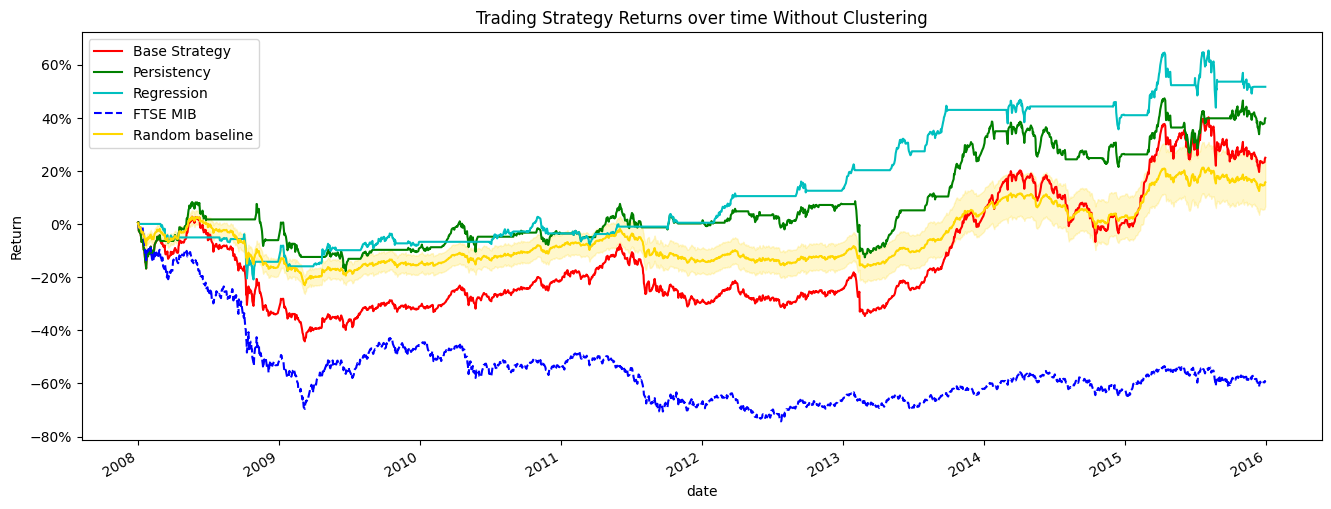

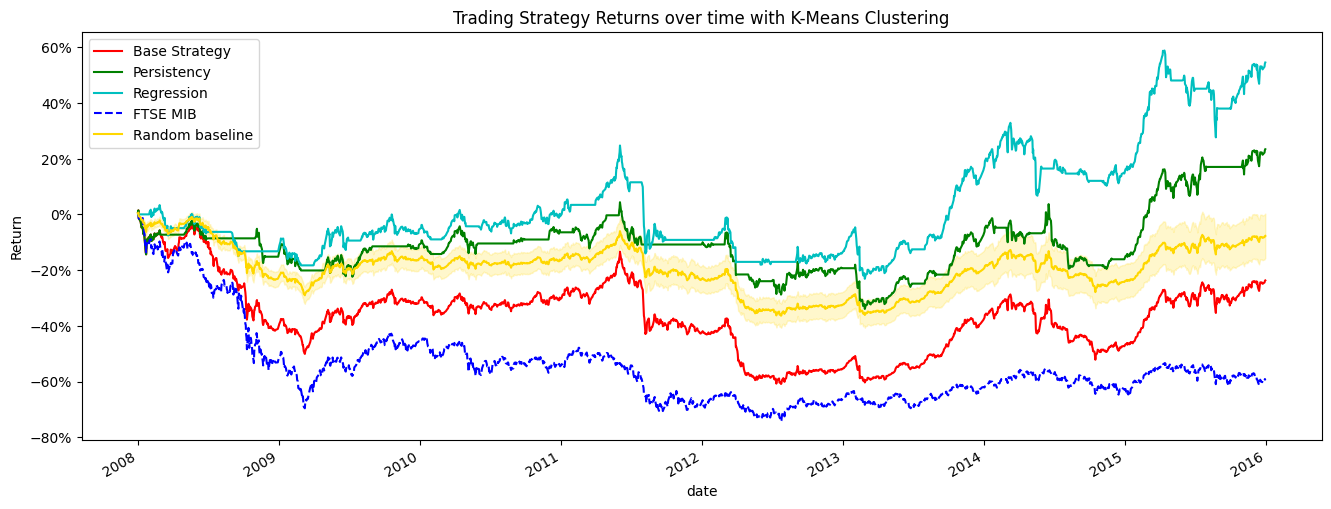

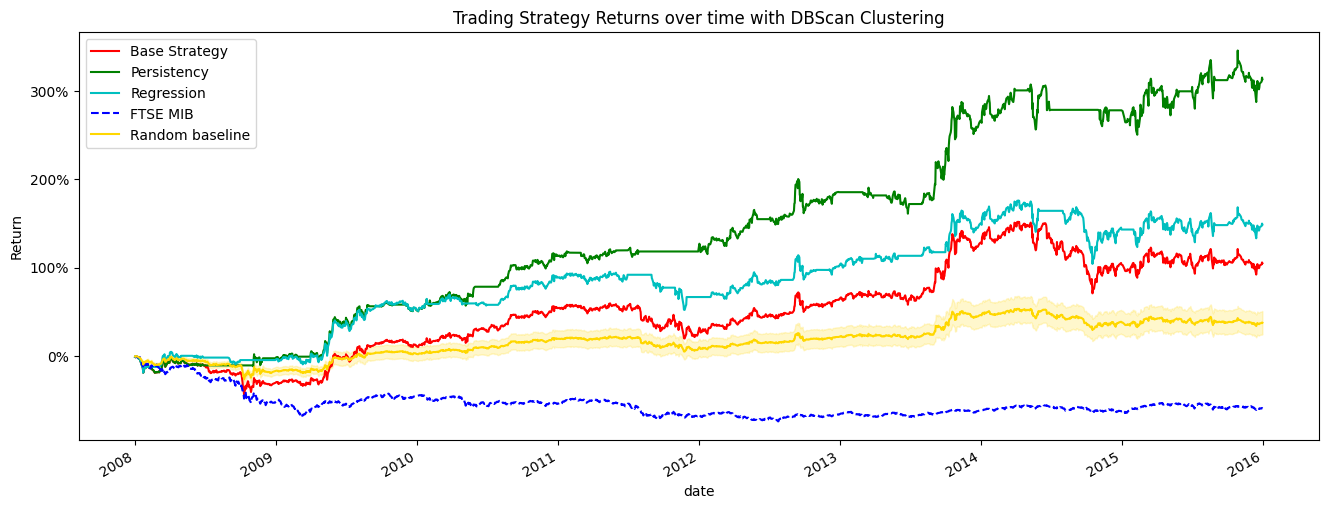

In [79]:
plot_portfolio_cumulative_return(result_training_no, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_train["no"],
                                 title= "Trading Strategy Returns over time Without Clustering",
                                 save_path= "./Results/Images/IT_noclust_train")

plot_portfolio_cumulative_return(result_training_km, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_train["km"],
                                 title= "Trading Strategy Returns over time with K-Means Clustering",
                                 save_path= "./Results/Images/IT_kmeans_train")

plot_portfolio_cumulative_return(result_training_db, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_train["db"],
                                 title= "Trading Strategy Returns over time with DBScan Clustering",
                                 save_path= "./Results/Images/IT_dbscan_train")


In [65]:
volatility_no = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_train_results_no]
sharpe_ratio_no = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_train_results_no]
cumulative_return_no = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_train_results_no]

volatility_km = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_train_results_km]
sharpe_ratio_km = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_train_results_km]
cumulative_return_km = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_train_results_km]

volatility_db = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_train_results_db]
sharpe_ratio_db = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_train_results_db]
cumulative_return_db = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_train_results_db]

results_training = np.array([
    volatility_no,
    sharpe_ratio_no,
    cumulative_return_no,
    volatility_km,
    sharpe_ratio_km,
    cumulative_return_km,
    volatility_db,
    sharpe_ratio_db,
    cumulative_return_db,
])

index = pd.MultiIndex.from_product([["No-Clust", "K-Means", "DBSCAN"], ["Volatility", "Sharpe Ratio", "Cumulative Return"]], names= ["Clustering", "Measure"])

results_training_df = pd.DataFrame(results_training, index= index, columns= strat_names)
results_training_df

Base Strategy  Persistency  Regression
Clustering Measure                                                  
No-Clust   Volatility               0.01081      0.00790     0.00639
           Sharpe Ratio             0.01558      0.02487     0.03529
           Cumulative Return        0.24911      0.39765     0.51612
K-Means    Volatility               0.01252      0.00924     0.00971
           Sharpe Ratio            -0.00433      0.01586     0.02699
           Cumulative Return       -0.23712      0.23384     0.54519
DBSCAN     Volatility               0.01616      0.01275     0.01263
           Sharpe Ratio             0.02996      0.06125     0.04188
           Cumulative Return        1.04861      3.13313     1.48682

## Validation

In [35]:
best_rsi_data_M_km_val = data_validation.copy().dropna().groupby('date', 
                                                             group_keys=False).apply(lambda df: kmeans_best_rsi(df, 3))
chosen_stocks_km_val = list_monthly_stocks(best_rsi_data_M_km_val)

In [36]:
best_rsi_data_M_db_val =data_validation.copy().dropna().groupby('date',
                                                                group_keys = False).apply(lambda df: dbscan_best_rsi(df,3))
chosen_stocks_db_val = list_monthly_stocks(best_rsi_data_M_db_val)

In [37]:
chosen_stocks_noclust_val = list_monthly_stocks(data_validation.dropna())

In [38]:
all_stocks = list(df.reset_index(level= 0).index.unique())
stocks_km_val = list(np.unique([s for stocks_list in chosen_stocks_km_val.values() for s in stocks_list]))
stocks_db_val = list(np.unique([s for stocks_list in chosen_stocks_db_val.values() for s in stocks_list]))

start_date_val = data_validation.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date_val = data_validation.index.get_level_values('date').unique()[-1]

new_df_noclust_val = yf.download(tickers = all_stocks, 
                                 start = start_date_val, 
                                 end = end_date_val)

new_df_k_means_val = yf.download(tickers = stocks_km_val,
                             start = start_date_val, 
                             end = end_date_val)


new_df_db_val = yf.download(tickers = stocks_db_val,
                        start = start_date_val, 
                        end = end_date_val)

[*********************100%%**********************]  293 of 293 completed
[*********************100%%**********************]  182 of 182 completed
[*********************100%%**********************]  82 of 82 completed


In [39]:
p_val_results_no = []
p_val_results_km = []
p_val_results_db = []

In [40]:
p_val = daily_portfolio_return(chosen_stocks_noclust_val,
                                         new_df_noclust_val, 
                                         stop_loss = False)

p_km_val = daily_portfolio_return(chosen_stocks_km_val,
                                         new_df_k_means_val, 
                                         stop_loss = False)

p_db_val = daily_portfolio_return(chosen_stocks_db_val,
                                         new_df_db_val, 
                                         stop_loss = False)

p_val_results_no.append(p_val)
p_val_results_km.append(p_km_val)
p_val_results_db.append(p_db_val)

In [41]:
p_ps_val = daily_portfolio_return(chosen_stocks_noclust_val, 
                                         new_df_noclust_val,
                                         stop_loss= True,
                                        mode= "Persistency")

p_km_ps_val = daily_portfolio_return(chosen_stocks_km_val,
                                      new_df_k_means_val, 
                                      stop_loss= True,
                                      mode= "Persistency")

p_db_ps_val = daily_portfolio_return(chosen_stocks_db_val,
                                      new_df_db_val, 
                                      stop_loss = True,
                                        mode= "Persistency")

p_val_results_no.append(p_ps_val)
p_val_results_km.append(p_km_ps_val)
p_val_results_db.append(p_db_ps_val)

Number of times the filter has been used:  48
Number of times the filter has been used:  40
Number of times the filter has been used:  36


In [42]:
p_reg_val = daily_portfolio_return(chosen_stocks_noclust_val, 
                                         new_df_noclust_val,
                                         off_set_days= 30,
                                         stop_loss= True)

p_km_reg_val = daily_portfolio_return(chosen_stocks_km_val,
                                      new_df_k_means_val, 
                                      off_set_days = 30, 
                                      stop_loss = True)

p_db_reg_val = daily_portfolio_return(chosen_stocks_db_val,
                                      new_df_db_val, 
                                      off_set_days = 30,
                                      stop_loss = True)

p_val_results_no.append(p_reg_val)
p_val_results_km.append(p_km_reg_val)
p_val_results_db.append(p_db_reg_val)

Number of times the filter has been used:  27
Number of times the filter has been used:  13
Number of times the filter has been used:  24


In [43]:
if plot_arima:
    p_ARIMA_val = daily_portfolio_return(chosen_stocks_noclust_val,
                                            new_df_noclust_val,
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_km_ARIMA_val = daily_portfolio_return(chosen_stocks_km_val,
                                            new_df_k_means_val,
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_db_ARIMA_val = daily_portfolio_return(chosen_stocks_db_val,
                                            new_df_db_val,
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_val_results_no.append(p_ARIMA_val)
    p_val_results_km.append(p_km_ARIMA_val)
    p_val_results_db.append(p_db_ARIMA_val)

In [44]:
samples = 50
confidence_level = .97

baselines_val = {
    "no": get_random_baseline(chosen_stocks_noclust_val, new_df_noclust_val, samples, confidence_level),
    "km": get_random_baseline(chosen_stocks_km_val, new_df_k_means_val, samples, confidence_level),
    "db": get_random_baseline(chosen_stocks_db_val, new_df_db_val, samples, confidence_level)
}

Number of times the filter has been used:  2400
Number of times the filter has been used:  2387
Number of times the filter has been used:  2439


In [49]:
mib = yf.download(tickers='FTSEMIB.MI',
                  start = start_date_validation,
                  end = end_date_validation)

mib_ret = np.log(mib[['Adj Close']]).diff().dropna().rename({'Adj Close':'SP500'}, axis=1)

refering_index = {
    "name" : 'FTSE MIB',
    "return" : mib_ret
}

result_validation_no = pd.concat(p_val_results_no, axis=1)
result_validation_km = pd.concat(p_val_results_km, axis=1)
result_validation_db = pd.concat(p_val_results_db, axis=1)

strat_names = ['Base Strategy', 'Persistency', 'Regression']
if plot_arima: 
    strat_names += ['Arima']

result_validation_no.columns = strat_names
result_validation_km.columns = strat_names
result_validation_db.columns = strat_names

[*********************100%%**********************]  1 of 1 completed


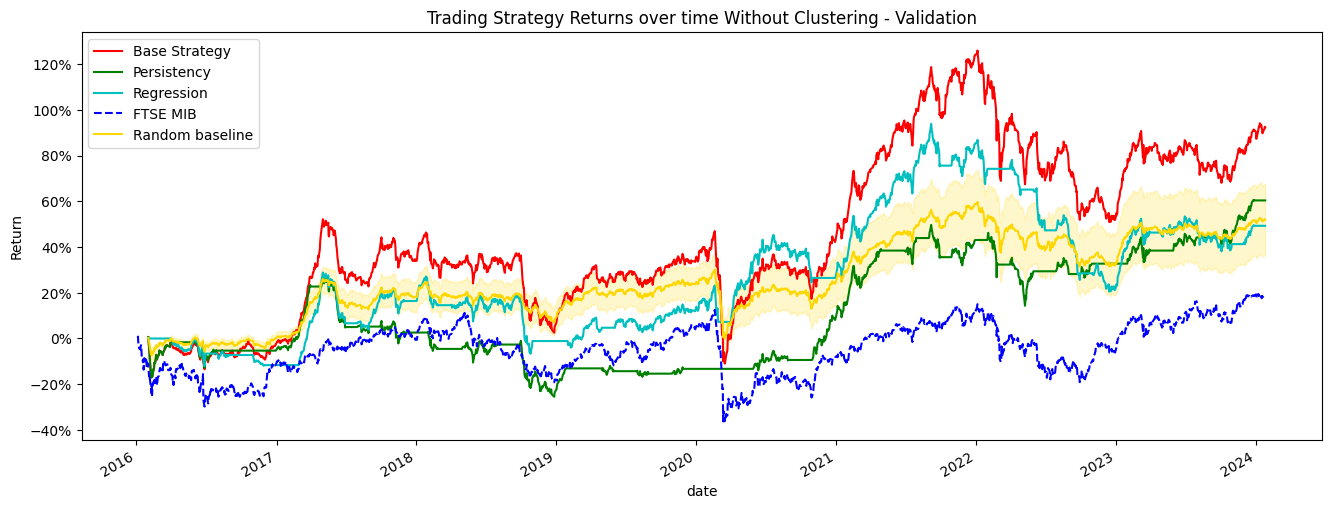

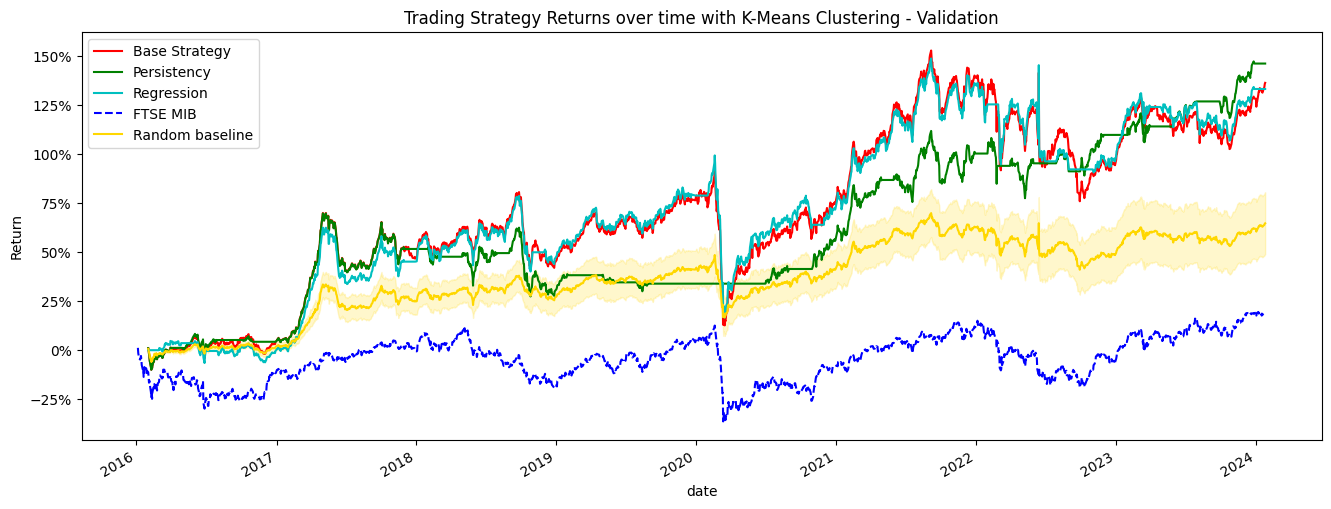

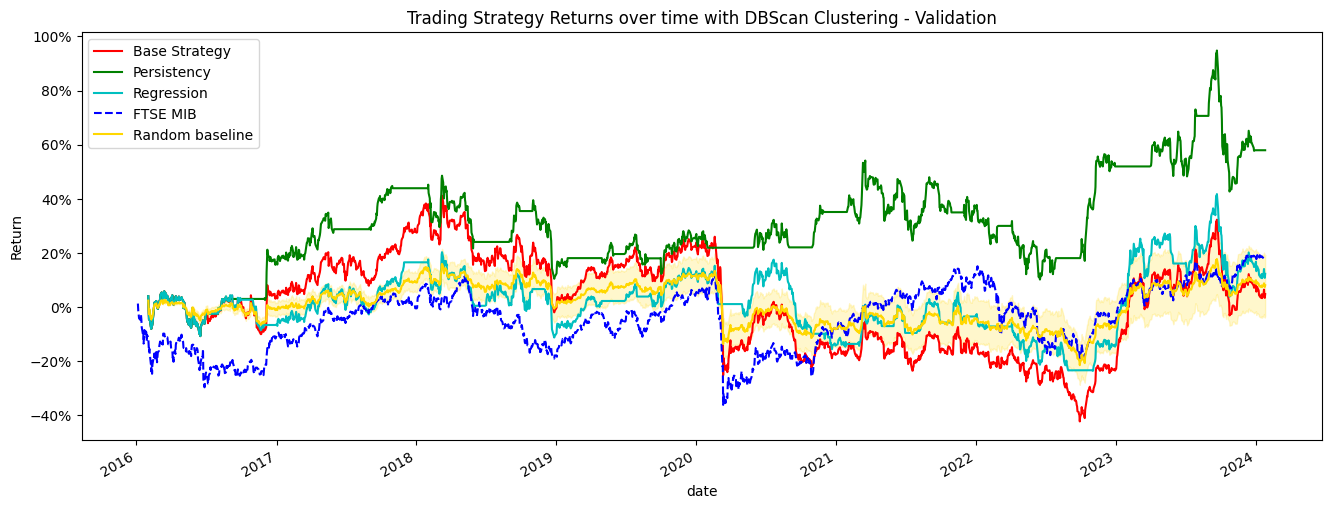

In [76]:
plot_portfolio_cumulative_return(result_validation_no, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_val["no"],
                                 title= "Trading Strategy Returns over time Without Clustering - Validation",
                                 save_path= "./Results/Images/IT_noclust_val.png")

plot_portfolio_cumulative_return(result_validation_km, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_val["km"],
                                 title= "Trading Strategy Returns over time with K-Means Clustering - Validation",
                                 save_path= "./Results/Images/IT_kmeans_val.png")

plot_portfolio_cumulative_return(result_validation_db, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_val["db"],
                                 title= "Trading Strategy Returns over time with DBScan Clustering - Validation",
                                 save_path= "./Results/Images/IT_dbscan_val.png")


In [69]:
volatility_no = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_val_results_no]
sharpe_ratio_no = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_val_results_no]
cumulative_return_no = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_val_results_no]

volatility_km = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_val_results_km]
sharpe_ratio_km = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_val_results_km]
cumulative_return_km = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_val_results_km]

volatility_db = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_val_results_db]
sharpe_ratio_db = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_val_results_db]
cumulative_return_db = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_val_results_db]

results_validation = np.array([
    volatility_no,
    sharpe_ratio_no,
    cumulative_return_no,
    volatility_km,
    sharpe_ratio_km,
    cumulative_return_km,
    volatility_db,
    sharpe_ratio_db,
    cumulative_return_db,
])

index = pd.MultiIndex.from_product([["No-Clust", "K-Means", "DBSCAN"], ["Volatility", "Sharpe Ratio", "Cumulative Return"]], names= ["Clustering", "Measure"])

results_validation_df = pd.DataFrame(results_validation, index= index, columns= strat_names)
results_validation_df

Base Strategy  Persistency  Regression
Clustering Measure                                                  
No-Clust   Volatility               0.01217      0.00857     0.00931
           Sharpe Ratio             0.03261      0.03140     0.02584
           Cumulative Return        0.92420      0.60401     0.49298
K-Means    Volatility               0.01322      0.00854     0.01257
           Sharpe Ratio             0.03865      0.05608     0.03947
           Cumulative Return        1.36155      1.45989     1.33041
DBSCAN     Volatility               0.01546      0.01149     0.01256
           Sharpe Ratio             0.00926      0.02529     0.01078
           Cumulative Return        0.04682      0.57909     0.12179

#### Save results

In [73]:
if not os.path.exists("./Results"):
    os.makedirs("./Results")
with pd.ExcelWriter("./Results/Italian_market.xlsx") as writer:
    results_training_df.to_excel(writer, sheet_name= "Training")
    results_validation_df.to_excel(writer, sheet_name= "Validation")